In [1]:
using Rocket
using BenchmarkTools
using ReactiveMP
using Distributions
using Plots

import ReactiveMP: make_node

┌ Info: Precompiling Rocket [df971d30-c9d6-4b37-b8ff-e965b2cb3a40]
└ @ Base loading.jl:1278
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278
┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [2]:
struct NonlinearTransform
    f :: Function
end

struct NonlinearNode
    transform :: NonlinearTransform
end

function ReactiveMP.make_node(transform::NonlinearTransform)
    return FactorNode(NonlinearNode, ReactiveMP.Stochastic, (:out, :in), ((1, 2), ), transform)
end

function ReactiveMP.make_node(transform::NonlinearTransform, out, input)
    node = make_node(transform)
    connect!(node, :out, out)
    connect!(node, :in, input)
    return node
end

In [ ]:
import ReactiveMP: @rule
import ForneyLab

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278
┌ Warning: Package ForneyLab does not have NLsolve in its dependencies:
│ - If you have ForneyLab checked out for development and have
│   added NLsolve as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ForneyLab
└ Loading NLsolve into ForneyLab from project dependency, future warnings for ForneyLab are suppressed.


In [ ]:
@rule(
    form => Type{ <: NonlinearNode },
    on   => :in,
    vconstraint => Marginalisation,
    messages => (m_out::NormalMeanVariance{T}, ) where { T <: Real },
    marginals => Nothing,
    meta      => NonlinearTransform,
    begin 
        vindex = ReactiveMP.varindex(__node, :in)
        vin    = @inbounds ReactiveMP.variables(__node)[vindex]
        kfn    = meta.f 
        return vin.m_in |> take(1) |> map(NormalMeanVariance, (m_in) -> begin
            alpha = 1e-3
            (m_fw_in1, V_fw_in1) = ReactiveMP.mean(m_in), ReactiveMP.cov(m_in)
            (m_tilde, V_tilde, C_tilde) = ForneyLab.unscentedStatistics(m_fw_in1, V_fw_in1, kfn; alpha=alpha)

            # RTS smoother
            (m_bw_out, V_bw_out) = ReactiveMP.mean(m_out), ReactiveMP.cov(m_out)
            (m_bw_in1, V_bw_in1) = ForneyLab.smoothRTSMessage(m_tilde, V_tilde, C_tilde, m_fw_in1, V_fw_in1, m_bw_out, V_bw_out)

            return NormalMeanVariance(m_bw_in1, V_bw_in1)
        end)
    end
)

@rule(
    form => Type{ <: NonlinearNode },
    on   => :out,
    vconstraint => Marginalisation,
    messages => (m_in::NormalMeanVariance{T}, ) where { T <: Real },
    marginals => Nothing,
    meta      => NonlinearTransform,
    begin 
        alpha = 1e-3
        (m_fw_in1, V_fw_in1)  = mean(m_in), cov(m_in)
        (m_tilde, V_tilde, _) = ForneyLab.unscentedStatistics(m_fw_in1, V_fw_in1, meta.f; alpha=alpha)
        
        return NormalMeanVariance(m_tilde, V_tilde)
    end
)

In [70]:
function nonlinear_kalman(observations, fn, y_var)

    model = Model(DefaultMessageGate())

    x_mean = datavar(model, :x_mean, Dirac{Float64})
    x_var  = datavar(model, :x_var, Dirac{Float64})
    x      = randomvar(model, :x)

    xgmv = make_node(model, NormalMeanVariance, x, x_mean, x_var)

    z = randomvar(model, :z)

    znl = make_node(model, NonlinearTransform(fn), z, x)

    y_var = constvar(model, :y_var, y_var)
    y = datavar(model, :y, Dirac{Float64})

    obs_node = make_node(model, NormalMeanVariance, y, z, y_var)

    activate!(model)
    
    marginals = Vector{NormalMeanVariance}()

    subscription = subscribe!(getmarginal(z), (m) -> push!(marginals, getdata(m)))
    
    x_mean_prior = 0.0
    x_var_prior  = 10.0
    
    for point in observations
        update!(y, point)
        update!(x_mean, x_mean_prior)
        update!(x_var, x_var_prior)

        x_mean_prior = mean(marginals[end])
        x_var_prior = cov(marginals[end])
    end
    
    unsubscribe!(subscription)
    
    return marginals
end

nonlinear_kalman (generic function with 2 methods)

In [155]:
N = 150

x_0_data = 0.01
a_data   = 1.05
y_var    = 0.1

x_data = Vector{Float64}(undef, N)
y_data = Vector{Float64}(undef, N)

fn = (x) -> a_data * x

x_t_min_data = x_0_data


for t in 1:N
    x_data[t] = fn(x_t_min_data)
    y_data[t] = rand(Normal(x_data[t], sqrt(y_var)))
    
    x_t_min_data = x_data[t]
end    
;

In [156]:
marginals = nonlinear_kalman(y_data, fn, y_var);

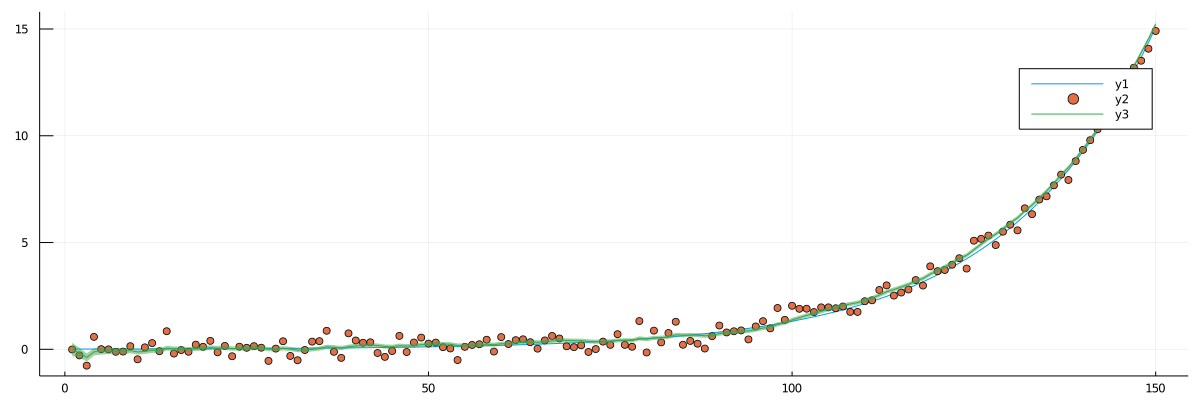

In [157]:
pane = plot(x_data)
pane = scatter!(pane, y_data)
pane = plot!(pane, mean.(marginals), ribbon = std.(marginals))

plot(pane, size = (1200, 400))